In [1]:
# Python packages and utilities
import importlib
from IPython.display import display, HTML

# imbalanced learn
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN
import logging
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import os
import pandas as pd
from PIL import Image

# RDKit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.ML.Cluster import Butina

# scikit-learn
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import shap
import sys

# seaborn
import seaborn as sns

# scikitplot library
import scikitplot as skplt

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import workflow_functions as wf
from pythia import scaling

# Utility
%load_ext autoreload
%autoreload 2
%aimport

# Configure logging
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# Set random seed
random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")


/Users/matina/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

In [3]:
data = pd.read_csv("DFTdata.csv",header=None)

In [4]:
data

,0,1,2,3,4,...,39,40,41,42,43
0,-5.79,-1.47,-0.148,1.79,5.17,...,11.57,3.84,2.72,11.50,-30
1,-5.83,-2.40,-0.149,1.82,6.86,...,11.57,3.84,2.72,11.50,-30
2,-5.79,-1.47,-0.148,1.79,5.17,...,9.79,9.09,3.03,7.92,-30
3,-5.83,-2.40,-0.149,1.82,6.86,...,9.79,9.09,3.03,7.92,-30
4,-5.79,-1.47,-0.148,1.79,5.17,...,9.75,8.83,3.12,8.31,-30
...,...,...,...,...,...,...,...,...,...,...,...
114,-5.57,-2.16,-0.166,2.08,6.56,...,11.57,3.84,2.72,11.50,-75
115,-5.79,-1.47,-0.148,1.79,5.17,...,12.11,2.49,1.55,11.53,-30
116,-5.83,-2.40,-0.149,1.82,6.86,...,12.11,2.49,1.55,11.53,-30
117,-5.57,-2.17,-0.159,2.31,6.56,...,12.11,2.49,1.55,11.53,-75


Now we read the csv that contains the endpoints (actual values) we want to train our model on

In [5]:
ddg = pd.read_csv("DDG.csv",header=None)

In [6]:
ddg

,0
0,0.569810
1,1.761325
2,1.251493
3,5.229434
4,2.678563
...,...
114,0.000000
115,0.000000
116,0.000000
117,0.000000


Here I make a folder that will contain the results of this notebook

In [7]:
os.makedirs("results_class_DFT", exist_ok=True)
os.chdir("results_class_DFT")

# Classify Molecules

We use these next cells to classify the ddg values into 'good' and 'bad'. Because the ddg values are continuous, we need to define a threshold value to separate the 'good' and 'bad' molecules. Here we define the threshold value as 4kJ/mol. If the target value is lower than the threshold value, we assign the class label 'class 0', which means the molecule is 'bad'. If the target value is higher than the threshold value, we assign the class label 'class 1', which means the molecule is 'good'.

Note that how to define the class labels depends on the problem. For example, if we want to predict whether a molecule is toxic or not, we can define a threshold value and assign the class labels accordingly. 

In [8]:
classes=[]
for index, value in ddg[0].items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [9]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = data.copy()
features_and_classes_df["classes"] = classes
feature_types = "no_categorical"

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balance between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [10]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [11]:
log.info("Feature decriptions:\n{}".format(data.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Classes/Targets descriptions:
['classes']


Sample using smote to balance the dataset using synthetic samples for the under represented class.

In [12]:
features_smote, classes_smote = sm.fit_resample(data.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(data.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

SMOTE has added 29 sythetic features to balance the classes


In [13]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[ -5.79        -1.47        -0.148      ...   2.72        11.5
  -30.        ]
 [ -5.83        -2.4         -0.149      ...   2.72        11.5
  -30.        ]
 [ -5.79        -1.47        -0.148      ...   3.03         7.92
  -30.        ]
 ...
 [ -5.57        -2.16        -0.166      ...   0.           0.
  -75.        ]
 [ -5.61010021  -1.95714009  -0.16411293 ...   2.58082867  11.68163038
  -73.82058193]
 [ -5.79        -1.47        -0.148      ...   3.12         8.31
  -30.        ]]
(148, 44)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(148,)


In [14]:
features_smote_df = pd.DataFrame(data=features_smote, columns=data.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

,0,1,2,3,4,...,40,41,42,43,classes
0,-5.790000,-1.470000,-0.148000,1.790000,5.170000,...,3.840000,2.720000,11.500000,-30.000000,0
1,-5.830000,-2.400000,-0.149000,1.820000,6.860000,...,3.840000,2.720000,11.500000,-30.000000,0
2,-5.790000,-1.470000,-0.148000,1.790000,5.170000,...,9.090000,3.030000,7.920000,-30.000000,0
3,-5.830000,-2.400000,-0.149000,1.820000,6.860000,...,9.090000,3.030000,7.920000,-30.000000,1
4,-5.790000,-1.470000,-0.148000,1.790000,5.170000,...,8.830000,3.120000,8.310000,-30.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
143,-5.736321,-1.292643,-0.159471,1.978858,4.721075,...,6.110000,2.130000,12.270000,-70.000000,0
144,-5.398592,-2.128627,-0.168856,3.818556,7.753503,...,6.110000,2.573398,10.740599,-75.140843,0
145,-5.570000,-2.160000,-0.166000,2.080000,6.560000,...,0.000000,0.000000,0.000000,-75.000000,0
146,-5.610100,-1.957140,-0.164113,2.042259,6.048133,...,4.375456,2.580829,11.681630,-73.820582,0


## Using balanced classes Kfold
This section tests the relience of the model on the training set. 

First, we define the different classifiers we want to try.

In [15]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs", max_iter=100000)]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [16]:
%%capture
wf.kfold_test_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
           dtype='int64')
Features:            0         1         2         3         4         5         6   \
0   -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000  6.460000   
1   -5.830000 -2.400000 -0.149000  1.820000  6.860000  3.930000  6.500000   
2   -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000  6.460000   
3   -5.830000 -2.400000 -0.149000  1.820000  6.860000  3.930000  6.500000   
4   -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000  6.460000   
..        ...       ...       ...       ...       ...       ...       ...   
143 -5.736321 -1.292643 -0.159471  1.978858  4.721075  2.072643  5.999854   
144 -5.398592 -2.128627 -0.168856  3.818556  7.753503  1.998556  6.482570   
145 -5.570000 -2.160000 -0.166000  2.080000  6.5

	Best parameters; {'n_neighbors': 5}
	0.8229 (+/-0.0910) for {'n_neighbors': 2}
	0.8341 (+/-0.0656) for {'n_neighbors': 3}
	0.8326 (+/-0.0510) for {'n_neighbors': 4}
	0.8351 (+/-0.0407) for {'n_neighbors': 5}
	0.8134 (+/-0.0381) for {'n_neighbors': 6}
	0.8008 (+/-0.0373) for {'n_neighbors': 7}
	0.7739 (+/-0.0499) for {'n_neighbors': 8}
	0.7350 (+/-0.0523) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.8839285714285715
	Confusion matrix (NearestNeighbors):
[[6 1]
 [1 7]]


	score (NearestNeighbors): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.86      0.88      0.86      0.87      0.75         7
          1       0.88      0.88      0.86      0.88      0.87      0.75         8

avg / total       0.87      0.87      0.87      0.87      0.87      0.75        15

	 Index | Predicted | Lab

	0.8393 (+/-0.0807) for {'n_neighbors': 2}
	0.8721 (+/-0.0890) for {'n_neighbors': 3}
	0.8452 (+/-0.0810) for {'n_neighbors': 4}
	0.8360 (+/-0.0832) for {'n_neighbors': 5}
	0.8212 (+/-0.0678) for {'n_neighbors': 6}
	0.8054 (+/-0.0645) for {'n_neighbors': 7}
	0.8039 (+/-0.0571) for {'n_neighbors': 8}
	0.7773 (+/-0.0684) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.7840909090909091
	Confusion matrix (NearestNeighbors):
[[8 3]
 [2 2]]


	score (NearestNeighbors): 0.6666666666666666
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.73      0.50      0.76      0.60      0.37        11
          1       0.40      0.50      0.73      0.44      0.60      0.36         4

avg / total       0.69      0.67      0.56      0.68      0.60      0.37        15

	 Index | Predicted | Label
	------------------
	13   |   1   

	0.6929 (+/-0.0730) for {'n_neighbors': 2}
	0.7101 (+/-0.0714) for {'n_neighbors': 3}
	0.7495 (+/-0.0985) for {'n_neighbors': 4}
	0.7819 (+/-0.1080) for {'n_neighbors': 5}
	0.7505 (+/-0.1423) for {'n_neighbors': 6}
	0.7199 (+/-0.1683) for {'n_neighbors': 7}
	0.7219 (+/-0.1593) for {'n_neighbors': 8}
	0.7234 (+/-0.1311) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.9791666666666667
	Confusion matrix (NearestNeighbors):
[[4 2]
 [0 8]]


	score (NearestNeighbors): 0.8571428571428571
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64         6
          1       0.80      1.00      0.67      0.89      0.82      0.69         8

avg / total       0.89      0.86      0.81      0.85      0.82      0.67        14

	 Index | Predicted | Label
	------------------
	1   |   0   |

	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8809 (+/-0.0804) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8663 (+/-0.0754) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8583 (+/-0.0800) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8583 (+/-0.0800) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: GaussianProcess -----
	ROC analysis area under the curve: 0.8
	Confusion matrix (GaussianProcess):
[[4 1]
 [1 9]]


	score (GaussianProcess): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.80      0.90      0.80      0.85      0.71         5
          1       0.90      0.90      0.80      0.90      0.85      0.73        10

avg / total       0.87      0.87      0.83      0.87      0.85      0.72        15

	 Index | Predicted | Label
	------------------
	5 

	0.8700 (+/-0.0750) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8735 (+/-0.0733) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8759 (+/-0.0650) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8759 (+/-0.0650) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: GaussianProcess -----
	ROC analysis area under the curve: 0.8928571428571428
	Confusion matrix (GaussianProcess):
[[5 3]
 [2 5]]


	score (GaussianProcess): 0.6666666666666666
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.62      0.71      0.67      0.67      0.44         8
          1       0.62      0.71      0.62      0.67      0.67      0.45         7

avg / total       0.67      0.67      0.67      0.67      0.67      0.45        15

	 Index | Predicted | Label
	------------------
	3   |   0   |   1
	4   |   0   |   0
	7   |   1   |   1

	Best parameters; {'max_depth': 5}
	0.7363 (+/-0.1603) for {'max_depth': 2}
	0.7817 (+/-0.0977) for {'max_depth': 3}
	0.7654 (+/-0.0987) for {'max_depth': 4}
	0.7879 (+/-0.0809) for {'max_depth': 5}
	0.7797 (+/-0.0953) for {'max_depth': 7}
	0.7824 (+/-0.0929) for {'max_depth': 10}

	----- Predicting using: DecisionTree -----
	ROC analysis area under the curve: 0.9196428571428572
	Confusion matrix (DecisionTree):
[[6 1]
 [0 8]]


	score (DecisionTree): 0.9333333333333333
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      1.00      0.92      0.93      0.84         7
          1       0.89      1.00      0.86      0.94      0.93      0.87         8

avg / total       0.94      0.93      0.92      0.93      0.93      0.86        15

	 Index | Predicted | Label
	------------------
	0   |   0   |   0
	6   |   1   |   1
	25   |   1   |   1
	30   |   1   |   0
	49   |   

	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.73      1.00      0.84      0.85      0.71        11
          1       0.57      1.00      0.73      0.73      0.85      0.75         4

avg / total       0.89      0.80      0.93      0.81      0.85      0.72        15

	 Index | Predicted | Label
	------------------
	13   |   1   |   0
	28   |   1   |   1
	32   |   1   |   0
	59   |   0   |   0
	61   |   0   |   0
	63   |   0   |   0
	66   |   1   |   1
	72   |   1   |   0
	79   |   1   |   1
	89   |   1   |   1
	103   |   0   |   0
	120   |   0   |   0
	122   |   0   |   0
	128   |   0   |   0
	137   |   0   |   0
-----

----- DecisionTree: Fold 6 -----
[11, 17, 19, 23, 26, 36, 40, 45, 75, 96, 107, 113, 133, 135, 144]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  20
  21  22  24  25  27  28  29  30  31  32  33  34  35  37  38  39  41  42
  43  44  46  

All points have been used in a test case over all fold as they should have been
[[0.9125     0.80423882]
 [0.79344156 0.93571429]
 [0.83644274 0.85335937]
 [7.4        7.4       ]] [[0.14246101 0.12560808]
 [0.1028413  0.10444215]
 [0.07620245 0.07409986]
 [1.9078784  2.00997512]] 0.8655303030303031 0.05383120582003508

-----
Begin ExtraTreesClassifier
-----

----- ExtraTreesClassifier: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 

	0.8299 (+/-0.1316) for {'max_depth': 4, 'n_estimators': 50}
	0.8283 (+/-0.1332) for {'max_depth': 4, 'n_estimators': 100}
	0.8092 (+/-0.1285) for {'max_depth': 5, 'n_estimators': 10}
	0.8213 (+/-0.1308) for {'max_depth': 5, 'n_estimators': 20}
	0.8211 (+/-0.1399) for {'max_depth': 5, 'n_estimators': 50}
	0.8310 (+/-0.1363) for {'max_depth': 5, 'n_estimators': 100}
	0.8015 (+/-0.1256) for {'max_depth': 7, 'n_estimators': 10}
	0.8513 (+/-0.0866) for {'max_depth': 7, 'n_estimators': 20}
	0.8452 (+/-0.1074) for {'max_depth': 7, 'n_estimators': 50}
	0.8565 (+/-0.1090) for {'max_depth': 7, 'n_estimators': 100}
	0.8835 (+/-0.0775) for {'max_depth': 10, 'n_estimators': 10}
	0.9006 (+/-0.0724) for {'max_depth': 10, 'n_estimators': 20}
	0.8877 (+/-0.0704) for {'max_depth': 10, 'n_estimators': 50}
	0.8873 (+/-0.0720) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.9800000000000001
	Confusion matrix (ExtraTreesC

----- ExtraTreesClassifier: Fold 5 -----
[13, 28, 32, 59, 61, 63, 66, 72, 79, 89, 103, 120, 122, 128, 137]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  60  62  64  65  67  68  69  70  71  73  74  75  76  77  78  80
  81  82  83  84  85  86  87  88  90  91  92  93  94  95  96  97  98  99
 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 121 123 124 125 126 127 129 130 131 132 133 134 135 136 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [ 13  28  32  59  61  63  66  72  79  89 103 120 122 128 137]
	Best parameters; {'max_depth': 10, 'n_estimators': 100}
	0.7957 (+/-0.1225) for {'max_depth': 2, 'n_estimators': 10}
	0.7736 (+/-0.1274) for {'max_depth': 2, 'n_estimators': 20}
	0.7886 (+/-0.1236) for {'max_depth': 2, 'n_estimators': 50}
	0.7839 (+/-0.1289) for {'

	0.8855 (+/-0.0829) for {'max_depth': 7, 'n_estimators': 10}
	0.8997 (+/-0.0670) for {'max_depth': 7, 'n_estimators': 20}
	0.8833 (+/-0.0877) for {'max_depth': 7, 'n_estimators': 50}
	0.8844 (+/-0.0880) for {'max_depth': 7, 'n_estimators': 100}
	0.8845 (+/-0.0793) for {'max_depth': 10, 'n_estimators': 10}
	0.8902 (+/-0.0753) for {'max_depth': 10, 'n_estimators': 20}
	0.8892 (+/-0.0795) for {'max_depth': 10, 'n_estimators': 50}
	0.9077 (+/-0.0728) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.9285714285714286
	Confusion matrix (ExtraTreesClassifier):
[[7 1]
 [1 6]]


	score (ExtraTreesClassifier): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.88      0.86      0.88      0.87      0.75         8
          1       0.86      0.86      0.88      0.86      0.87      

[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Best parameters; {'n_estimators': 100}
	0.8163 (+/-0.1038) for {'n_estimators': 10}
	0.8221 (+/-0.1144) for {'n_estimators': 20}
	0.8381 (+/-0.1315) for {'n_estimators': 50}
	0.8648 (+/-0.1144) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 1.0
	Confu

	0.8441 (+/-0.0902) for {'n_estimators': 20}
	0.8616 (+/-0.0924) for {'n_estimators': 50}
	0.8722 (+/-0.1079) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 0.9821428571428571
	Confusion matrix (AdaBoost):
[[7 1]
 [1 6]]


	score (AdaBoost): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.88      0.86      0.88      0.87      0.75         8
          1       0.86      0.86      0.88      0.86      0.87      0.75         7

avg / total       0.87      0.87      0.87      0.87      0.87      0.75        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   1   |   1
	43   |   1   |   0
	54   |   1   |   1
	58   |   0   |   0
	90   |   1   |   1
	91   |   0   |   1
	106   |   0   |   0
	114   |   0   |   0
	117   |   0   |   0
	130

----- AdaBoost: Fold 9 -----
[1, 21, 44, 55, 69, 77, 82, 87, 92, 93, 132, 140, 143, 146]
	Train indx [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  45  46  47  48  49  50  51  52  53  54  56  57
  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76
  78  79  80  81  83  84  85  86  88  89  90  91  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 133 134 135 136
 137 138 139 141 142 144 145 147]
	Test indx: [  1  21  44  55  69  77  82  87  92  93 132 140 143 146]
	Best parameters; {'n_estimators': 100}
	0.7361 (+/-0.0729) for {'n_estimators': 10}
	0.7309 (+/-0.1863) for {'n_estimators': 20}
	0.7789 (+/-0.1036) for {'n_estimators': 50}
	0.7808 (+/-0.0740) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area und

----- LogisticRegression: Fold 3 -----
[5, 15, 22, 31, 35, 39, 47, 52, 64, 81, 83, 97, 119, 125, 141]
	Train indx [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  32  33  34  36  37  38  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  82  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 142 143 144 145 146 147]
	Test indx: [  5  15  22  31  35  39  47  52  64  81  83  97 119 125 141]
	Best parameters; {'C': 1.25, 'penalty': 'l2'}
	0.8422 (+/-0.1337) for {'C': 0.05, 'penalty': 'l2'}
	0.8464 (+/-0.1258) for {'C': 0.1, 'penalty': 'l2'}
	0.8547 (+/-0.1052) for {'C': 0.25, 'penalty': 'l2'}
	0.8656 (+/-0.0931) for {'C': 0.5, 'penalty': 'l2'}
	0.8754 (+/-0.

----- LogisticRegression: Fold 7 -----
[3, 4, 7, 20, 34, 38, 41, 67, 76, 94, 108, 110, 112, 138, 139]
	Train indx [  0   1   2   5   6   8   9  10  11  12  13  14  15  16  17  18  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  39  40  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  68  69  70  71  72  73  74  75  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  95  96  97  98  99
 100 101 102 103 104 105 106 107 109 111 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 140
 141 142 143 144 145 146 147]
	Test indx: [  3   4   7  20  34  38  41  67  76  94 108 110 112 138 139]
	Best parameters; {'C': 1.25, 'penalty': 'l2'}
	0.8729 (+/-0.1073) for {'C': 0.05, 'penalty': 'l2'}
	0.8773 (+/-0.1036) for {'C': 0.1, 'penalty': 'l2'}
	0.8846 (+/-0.0861) for {'C': 0.25, 'penalty': 'l2'}
	0.8935 (+/-0.0775) for {'C': 0.5, 'penalty': 'l2'}
	0.8956 (+/-0.

In [17]:
directory_names = wf.directory_names(kfold_clf_names)

## Analyses the output over all folds and predictions therefore for all molecules
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


NearestNeighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearestneighbors_DFT.png
['ddg_nearestneighbors_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 61, 'fp': 13, 'fn': 13, 'tp': 61}
[[61 13]
 [13 61]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussianprocess_DFT.png
['ddg_nearestneighbors_DFT.png', 'ddg_gaussianprocess_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 60, 'fp': 14, 'fn': 8, 'tp': 66}
[[60 14]
 [ 8 66]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

DecisionTree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decisiontree_DFT.png
['ddg_nearestneighbors_DFT.png', 'ddg_gaussianprocess_DFT.png', 'ddg_decisiontree_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 58, 'fp': 16, 'fn': 6, 'tp': 68}
[[58 16]
 [ 6 68]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_DFT.png
['ddg_nearestneighbors_DFT.png', 'ddg_gaussianprocess_DFT.png', 'ddg_decisiontree_DFT.png', 'ddg_extratreesclassifier_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 64, 'fp': 10, 'fn': 5, 'tp': 69}
[[64 10]
 [ 5 69]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_DFT.png
['ddg_nearestneighbors_DFT.png', 'ddg_gaussianprocess_DFT.png', 'ddg_decisiontree_DFT.png', 'ddg_extratreesclassifier_DFT.png', 'ddg_adaboost_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 62, 'fp': 12, 'fn': 9, 'tp': 65}
[[62 12]
 [ 9 65]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

LogisticRegression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logisticregression_DFT.png
['ddg_nearestneighbors_DFT.png', 'ddg_gaussianprocess_DFT.png', 'ddg_decisiontree_DFT.png', 'ddg_extratreesclassifier_DFT.png', 'ddg_adaboost_DFT.png', 'ddg_logisticregression_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 61, 'fp': 13, 'fn': 6, 'tp': 68}
[[61 13]
 [ 6 68]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearestneighbors     &  0.824324 &     0.824324 &     0.824324 &  0.648649 &   0.824324 &  0.824324 \\
gaussianprocess      &  0.851351 &     0.891892 &     0.810811 &  0.705024 &   0.825000 &  0.850386 \\
decisiontree         &  0.851351 &     0.918919 &     0.783784 &  0.709208 &   0.809524 &  0.848666 \\
extratreesclassifier &  0.898649 &     0.932432 &     0.864865 &  0.799124 &   0.873418 &  0.898013 \\
adaboost             &  0.858108 &     0.878378 &     0.837838 &  0.716806 &   0.844156 &  0.857869 \\
logisticregression   &  0.871622 &     0.918919 &     0.824324 &  0.746591 &   0.839506 &  0.870337 \\
\bottomrule
\end{tabular}



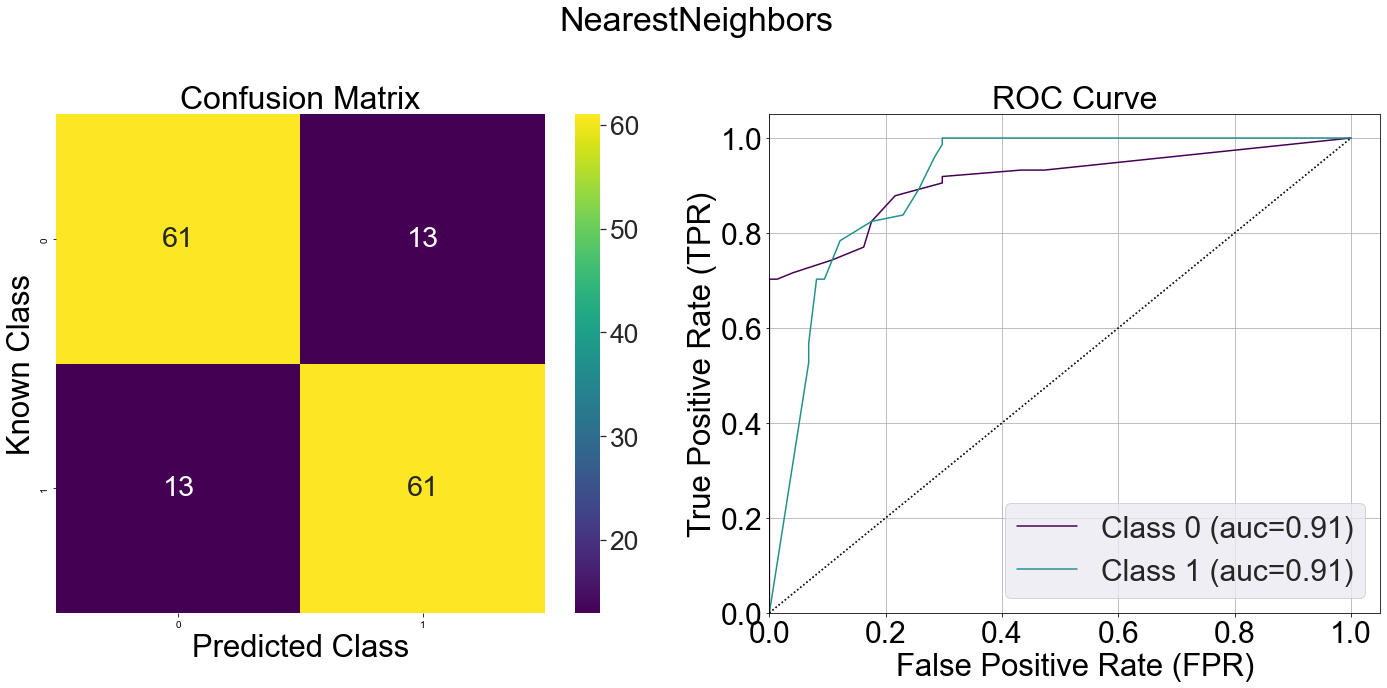

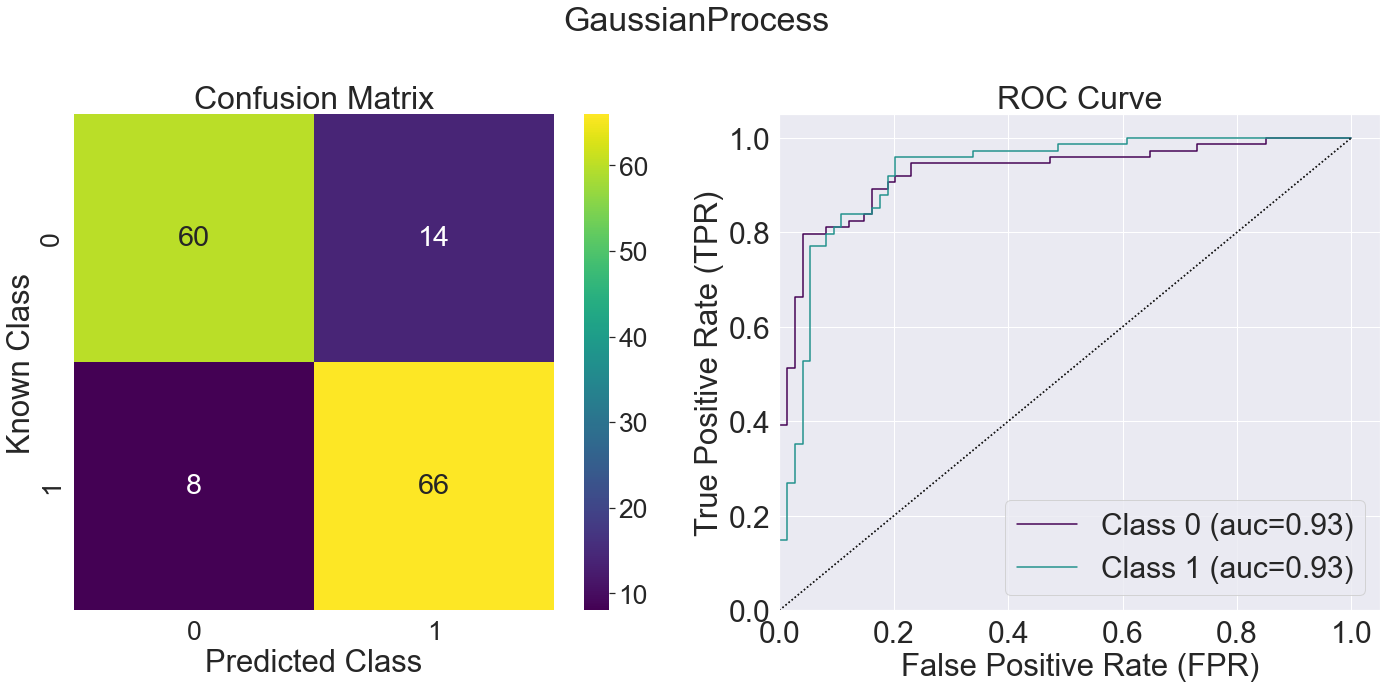

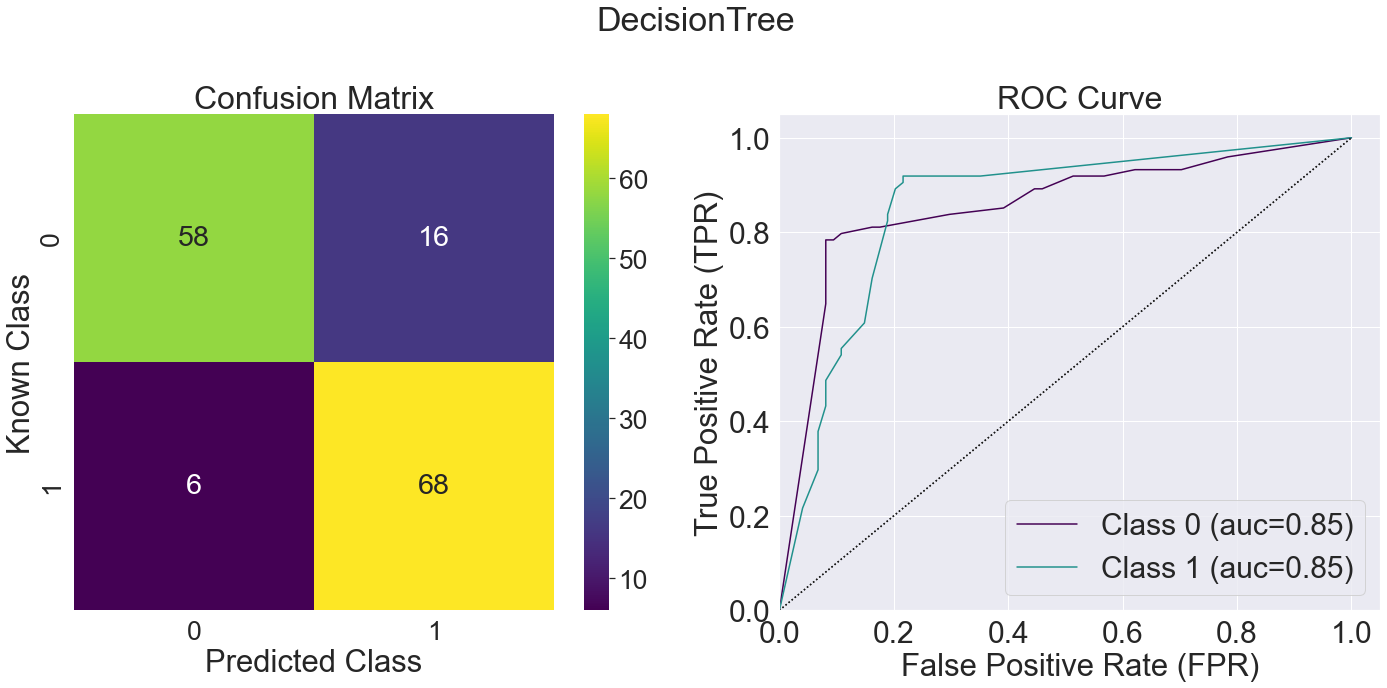

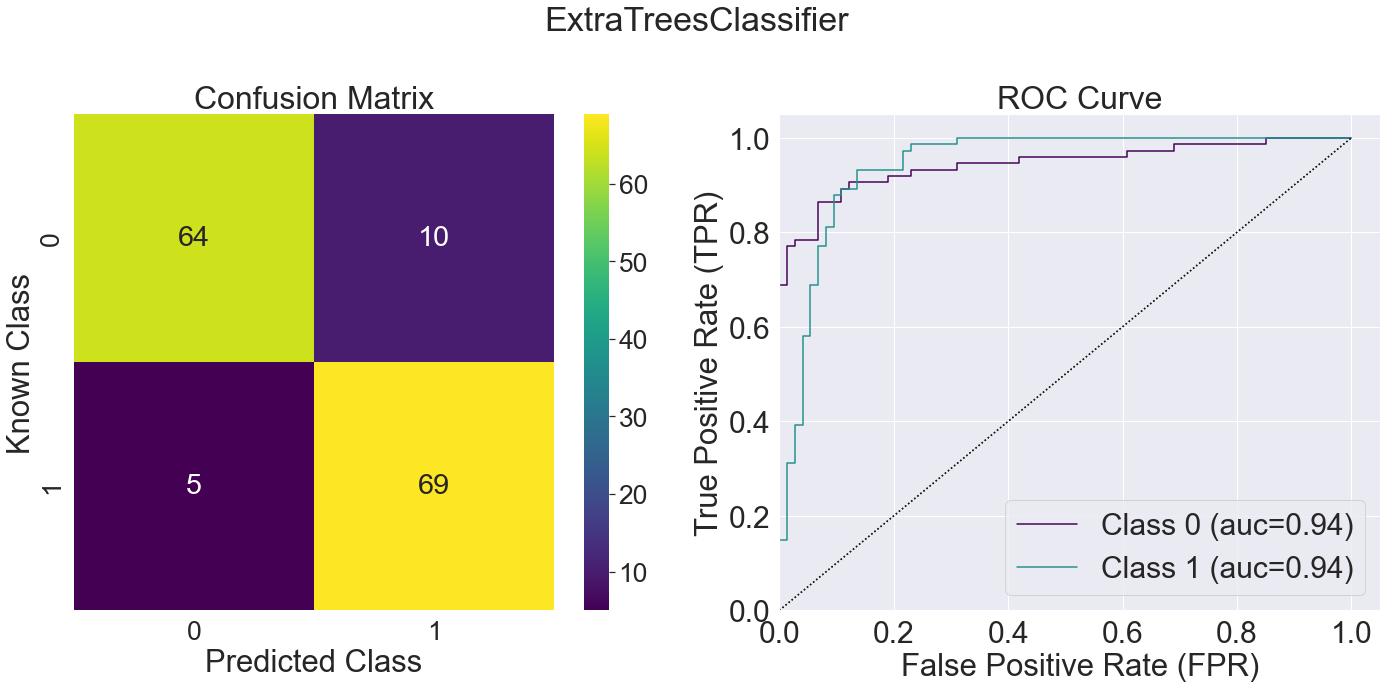

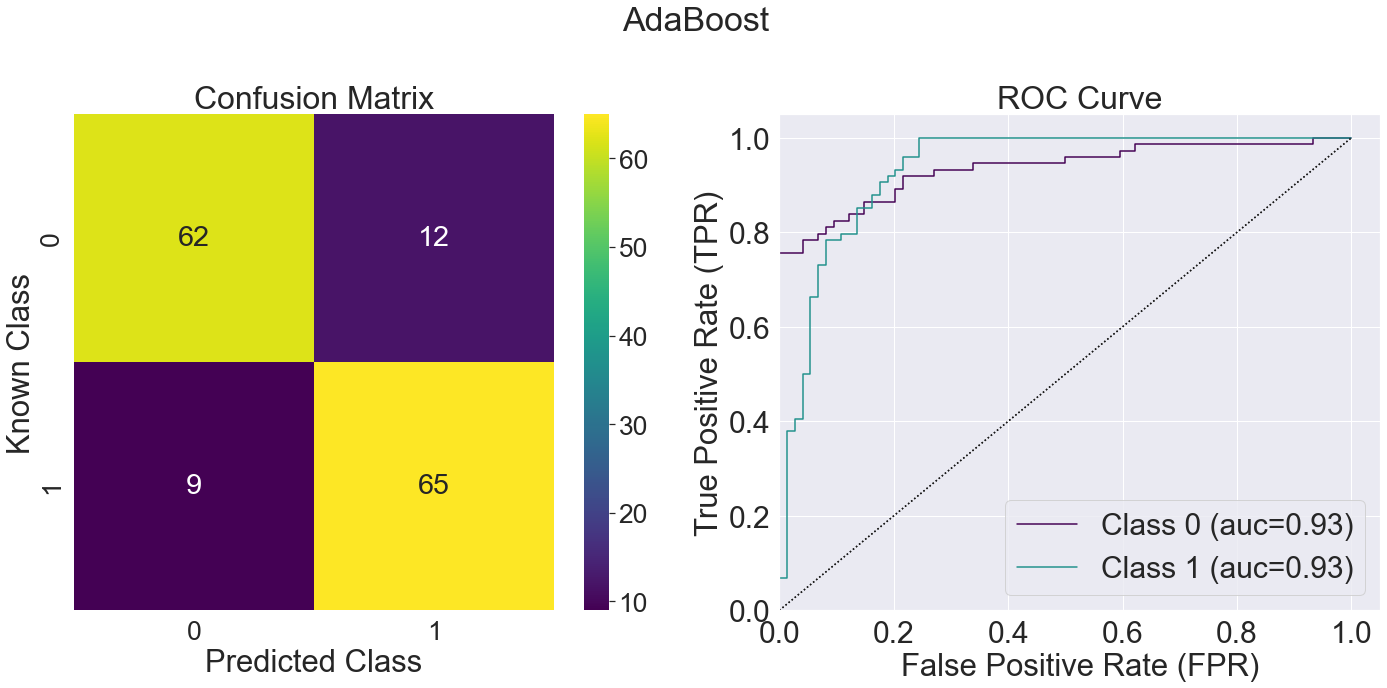

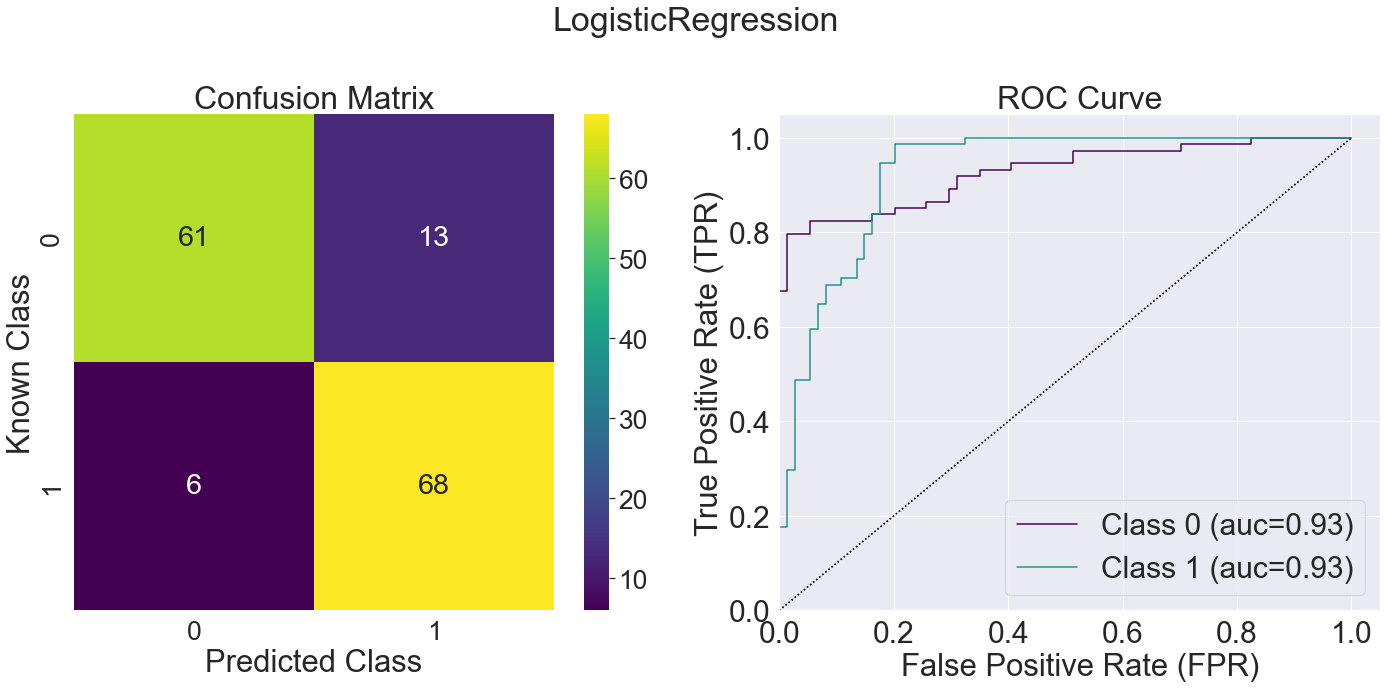

In [18]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=10)
    
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_DFT.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_DFT.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:dft_features")
log.info(df_metrics_for_paper.to_latex())

In [19]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_dft.png")

Combining 6 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:18000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000
Image 5 added at offset height 15000


# Now first we split 90%-10% (train-test)

In [20]:
data_df = pd.read_csv("../DFTdata.csv", header = None)

In [21]:
data_df.columns.tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

We know which data points we are using for test set, for consistency reasons. 
These are: 

In [22]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57, 52]

we romove from the data the test reactions

In [23]:
train_data = data_df.drop(labels =test_reactions, axis=0,inplace = False)

and we generate the test dataframe

In [24]:
test_data = pd.DataFrame()
test_data = data_df.iloc[test_reactions]

In [25]:
ddg = pd.read_csv("../DDG.csv", header = None)

In [26]:
ddg_train = ddg.drop(labels =test_reactions, axis=0,inplace = False)

In [27]:
ddg_test = ddg.iloc[test_reactions]

# Classify the training set

In [28]:
classes_train=[]
for index, value in ddg_train[0].items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [29]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = train_data.copy()
features_and_classes_df_train["classes"] = classes_train
feature_types = "no_categorical"

In [30]:
class_targets_df_train["classes"].values

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Synthetic Sampling for the training

In [31]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [32]:
log.info("Feature decriptions:\n{}".format(train_data.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Classes/Targets descriptions:
['classes']


In [33]:
features_smote_train, classes_smote_train = sm.fit_resample(train_data.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(train_data.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

SMOTE has added 29 sythetic features to balance the classes


In [34]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[ -5.79        -1.47        -0.148      ...   2.72        11.5
  -30.        ]
 [ -5.83        -2.4         -0.149      ...   2.72        11.5
  -30.        ]
 [ -5.79        -1.47        -0.148      ...   3.03         7.92
  -30.        ]
 ...
 [ -5.79        -1.47        -0.148      ...   3.07        11.86
  -30.        ]
 [ -5.79        -1.47        -0.148      ...   0.           0.
  -30.        ]
 [ -5.58846162  -2.02508814  -0.16472189 ...   2.73420125  11.27135991
  -75.42603744]]
(136, 44)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(136,)


In [35]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=train_data.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,classes
0,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.470000,3.670000,6.250000,...,3.030000,9.330000,3.550000,2.740000,11.570000,3.840000,2.720000,11.50000,-30.000000,0
1,-5.830000,-2.400000,-0.149000,1.820000,6.860000,3.930000,6.500000,6.500000,3.090000,6.260000,...,3.030000,9.330000,3.550000,2.740000,11.570000,3.840000,2.720000,11.50000,-30.000000,0
2,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.530000,2.510000,6.270000,...,3.000000,9.200000,3.550000,4.280000,9.790000,9.090000,3.030000,7.92000,-30.000000,0
3,-5.830000,-2.400000,-0.149000,1.820000,6.860000,3.930000,6.500000,6.560000,1.930000,6.280000,...,3.000000,9.200000,3.550000,4.280000,9.790000,9.090000,3.030000,7.92000,-30.000000,1
4,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.590000,1.350000,6.290000,...,2.970000,9.140000,3.550000,4.450000,9.750000,8.830000,3.120000,8.31000,-30.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.470000,3.670000,6.250000,...,3.030000,9.330000,3.550000,2.740000,11.570000,3.840000,2.720000,11.50000,-30.000000,0
132,-5.819138,-2.147468,-0.148728,1.811854,6.401097,3.848538,6.489138,6.491854,3.247493,6.257285,...,3.200444,8.614125,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-30.000000,0
133,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.470000,3.670000,6.250000,...,3.030000,9.290000,3.560000,3.640000,11.770000,4.580000,3.070000,11.86000,-30.000000,0
134,-5.790000,-1.470000,-0.148000,1.790000,5.170000,3.630000,6.460000,6.470000,3.670000,6.250000,...,2.605087,9.199037,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-30.000000,0


Now for the test set 

In [36]:
classes_test=[]
for index, value in ddg_test[0].items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [37]:
Xtrain = features_smote_df_train
Xtest = test_data
Ytrain = classes_smote_df_train
Ytest = classes_test

# Time for ML

In [38]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "RandomForest", "AdaBoost",
         "LogisticRegression"]
# add classifiers if you wish

kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    RandomForestClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs", max_iter=100000)]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "RandomForest": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [39]:
%%capture
wf.test_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, cv=5, n_repeats=10,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
           dtype='int64')
Using unscaled features
data:
     index         0         1         2         3         4         5  \
0        0 -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000   
1        1 -5.830000 -2.400000 -0.149000  1.820000  6.860000  3.930000   
2        2 -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000   
3        3 -5.830000 -2.400000 -0.149000  1.820000  6.860000  3.930000   
4        4 -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000   
..     ...       ...       ...       ...       ...       ...       ...   
131    131 -5.790000 -1.470000 -0.148000  1.790000  5.170000  3.630000   
132    132 -5.819138 -2.147468 -0.148728  1.811854  6.401097  3.848538   
133    133 -5.790000 -1.470000 -0.148000  1.790000  5.1

	0.8440 (+/-0.1182) for {'max_depth': 4, 'n_estimators': 20}
	0.8674 (+/-0.1173) for {'max_depth': 4, 'n_estimators': 50}
	0.8677 (+/-0.1203) for {'max_depth': 4, 'n_estimators': 100}
	0.8777 (+/-0.1024) for {'max_depth': 5, 'n_estimators': 10}
	0.8721 (+/-0.0964) for {'max_depth': 5, 'n_estimators': 20}
	0.8812 (+/-0.1071) for {'max_depth': 5, 'n_estimators': 50}
	0.8884 (+/-0.0957) for {'max_depth': 5, 'n_estimators': 100}
	0.8983 (+/-0.0835) for {'max_depth': 7, 'n_estimators': 10}
	0.8995 (+/-0.0804) for {'max_depth': 7, 'n_estimators': 20}
	0.8996 (+/-0.0843) for {'max_depth': 7, 'n_estimators': 50}
	0.8988 (+/-0.0880) for {'max_depth': 7, 'n_estimators': 100}
	0.8946 (+/-0.0813) for {'max_depth': 10, 'n_estimators': 10}
	0.9079 (+/-0.0743) for {'max_depth': 10, 'n_estimators': 20}
	0.9058 (+/-0.0802) for {'max_depth': 10, 'n_estimators': 50}
	0.9069 (+/-0.0780) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under

In [40]:
directory_names = wf.directory_names(kfold_clf_names)


NearestNeighbors
-------------

Reading 0.csv
Saving plot to ddg_nearestneighbors_dft.png
['ddg_nearestneighbors_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Saving plot to ddg_gaussianprocess_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

DecisionTree
-------------

Reading 0.csv
Saving plot to ddg_decisiontree_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png', 'ddg_decisiontree_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Saving plot to ddg_extratreesclassifier_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png', 'ddg_decisiontree_dft.png', 'ddg_extratreesclassifier_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

RandomForest
-------------

Reading 0.csv
Saving plot to ddg_randomforest_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png', 'ddg_decisiontree_dft.png', 'ddg_extratreesclassifier_dft.png', 'ddg_randomforest_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Saving plot to ddg_adaboost_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png', 'ddg_decisiontree_dft.png', 'ddg_extratreesclassifier_dft.png', 'ddg_randomforest_dft.png', 'ddg_adaboost_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

LogisticRegression
-------------

Reading 0.csv
Saving plot to ddg_logisticregression_dft.png
['ddg_nearestneighbors_dft.png', 'ddg_gaussianprocess_dft.png', 'ddg_decisiontree_dft.png', 'ddg_extratreesclassifier_dft.png', 'ddg_randomforest_dft.png', 'ddg_adaboost_dft.png', 'ddg_logisticregression_dft.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 1, 'tp': 5}
[[4 2]
 [1 5]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearestneighbors     &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
gaussianprocess      &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
decisiontree         &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
extratreesclassifier &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
randomforest         &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
adaboost             &  0.833333 &     1.000000 &     0.666667 &  0.707107 &   0.750000 &  0.816497 \\
logisticregression   &  0.750000 &     0.833333 &     0.666667 &  0.507093 &   0.714286 &  0.745356 \\
\bottomrule
\end{tabular}



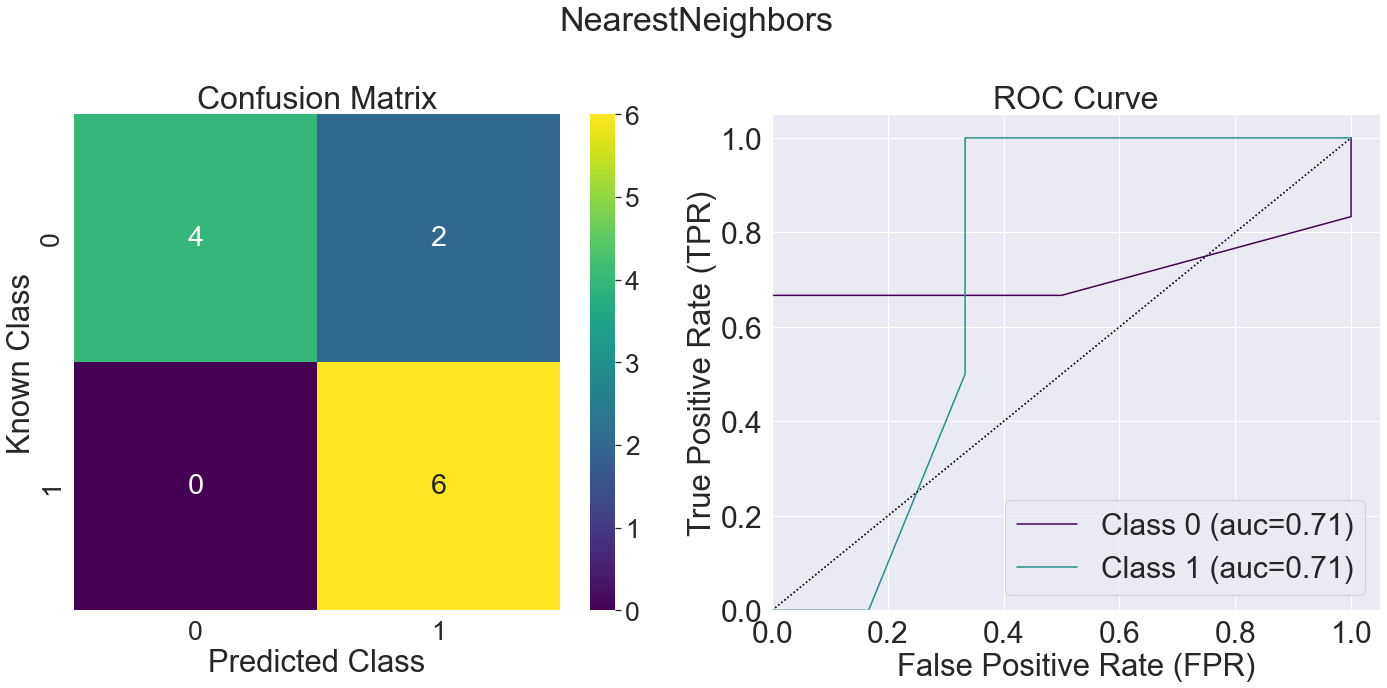

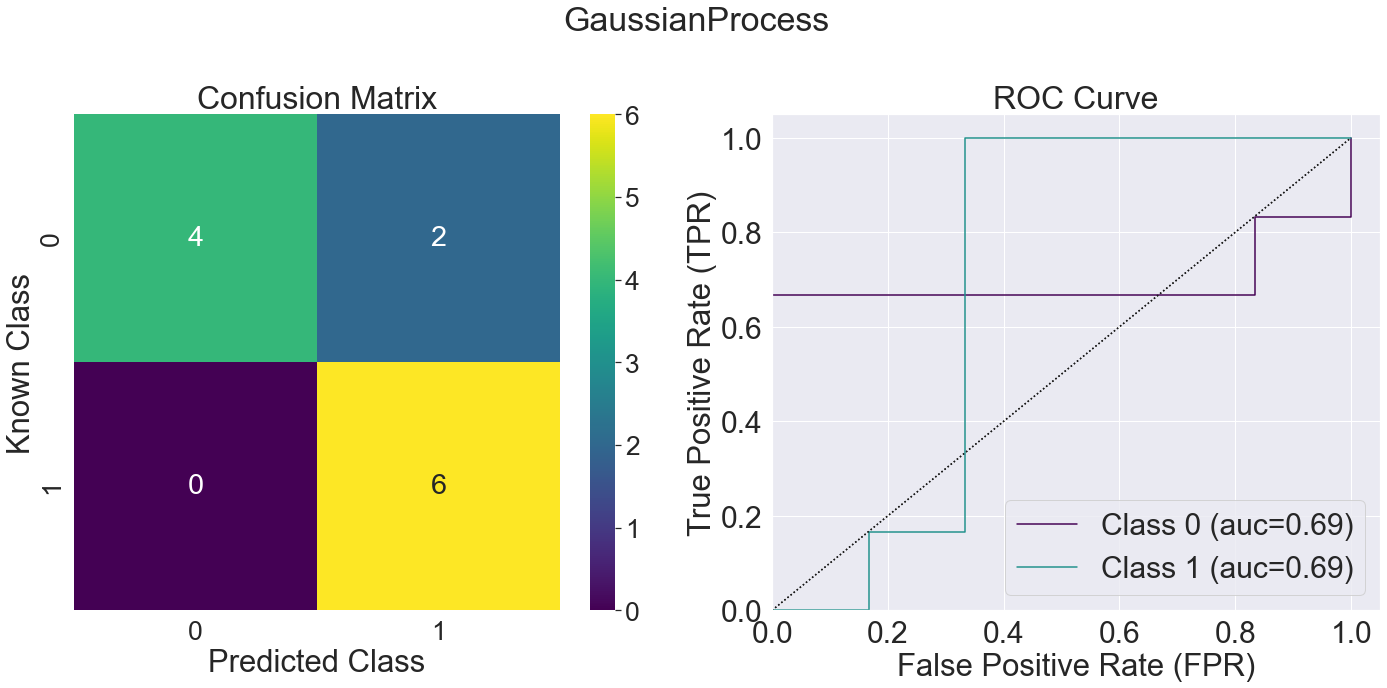

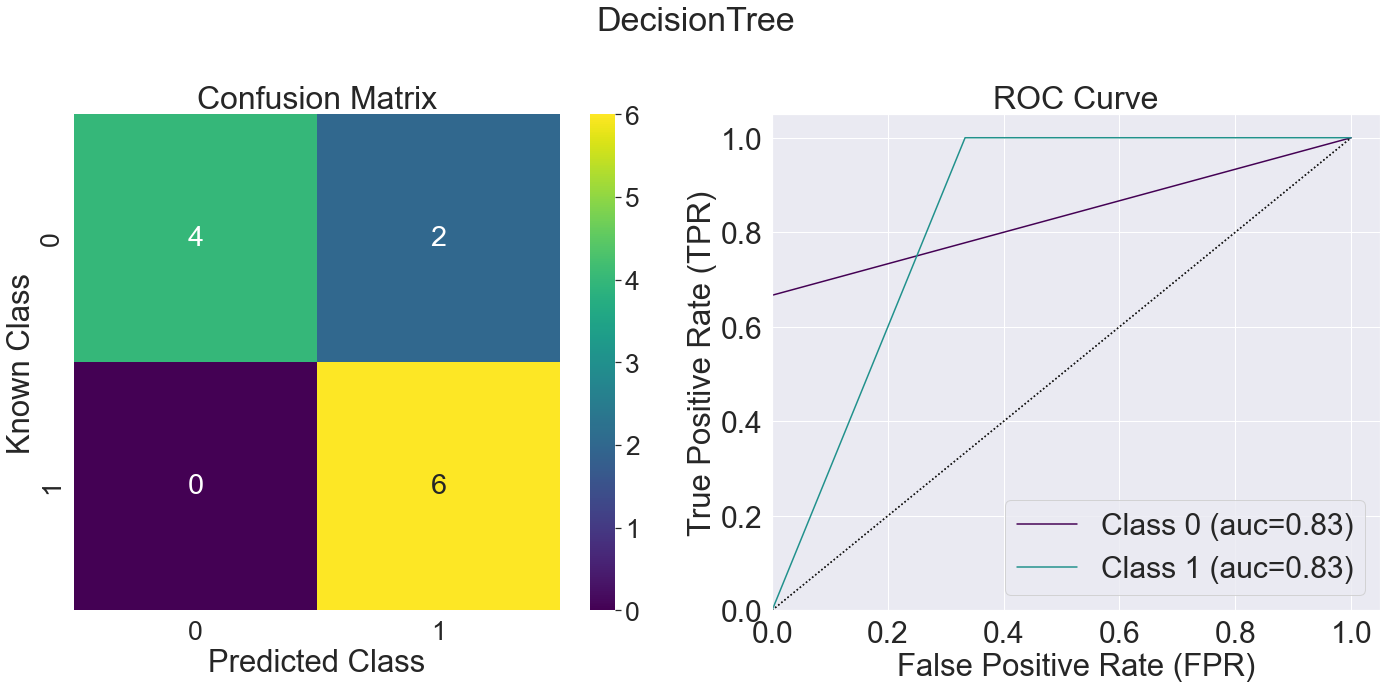

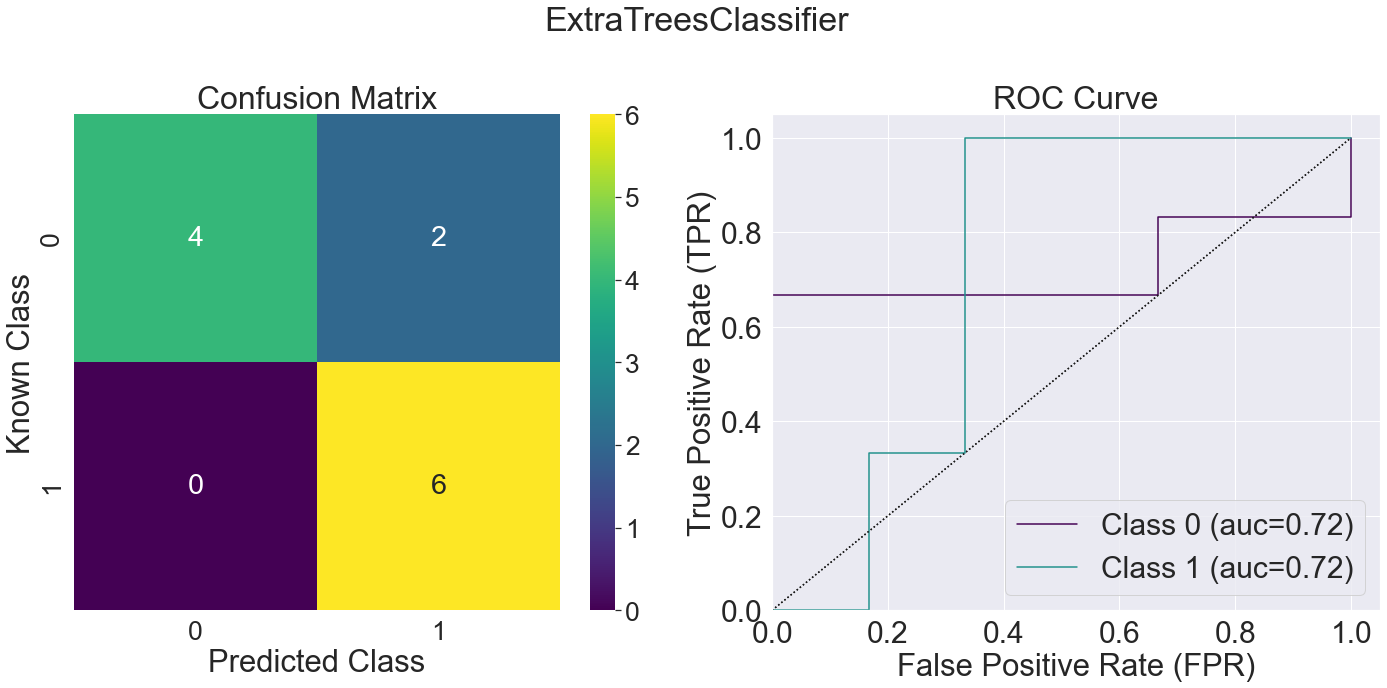

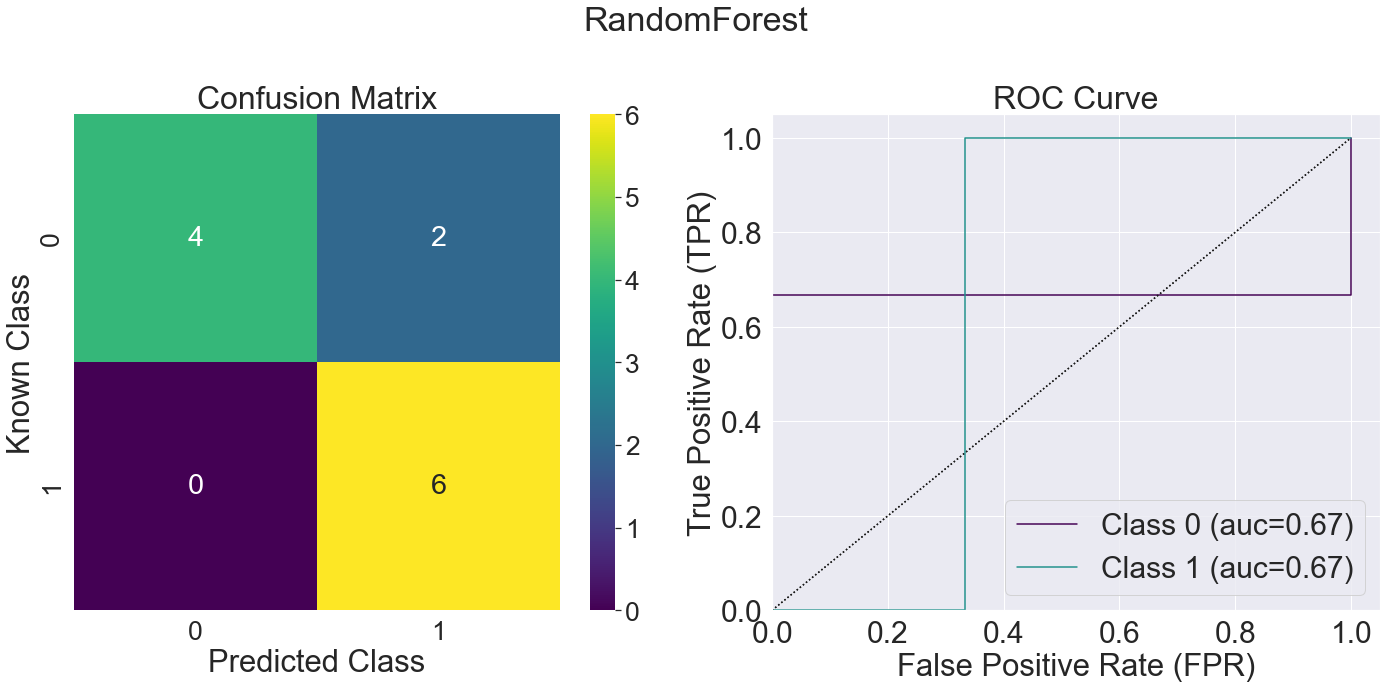

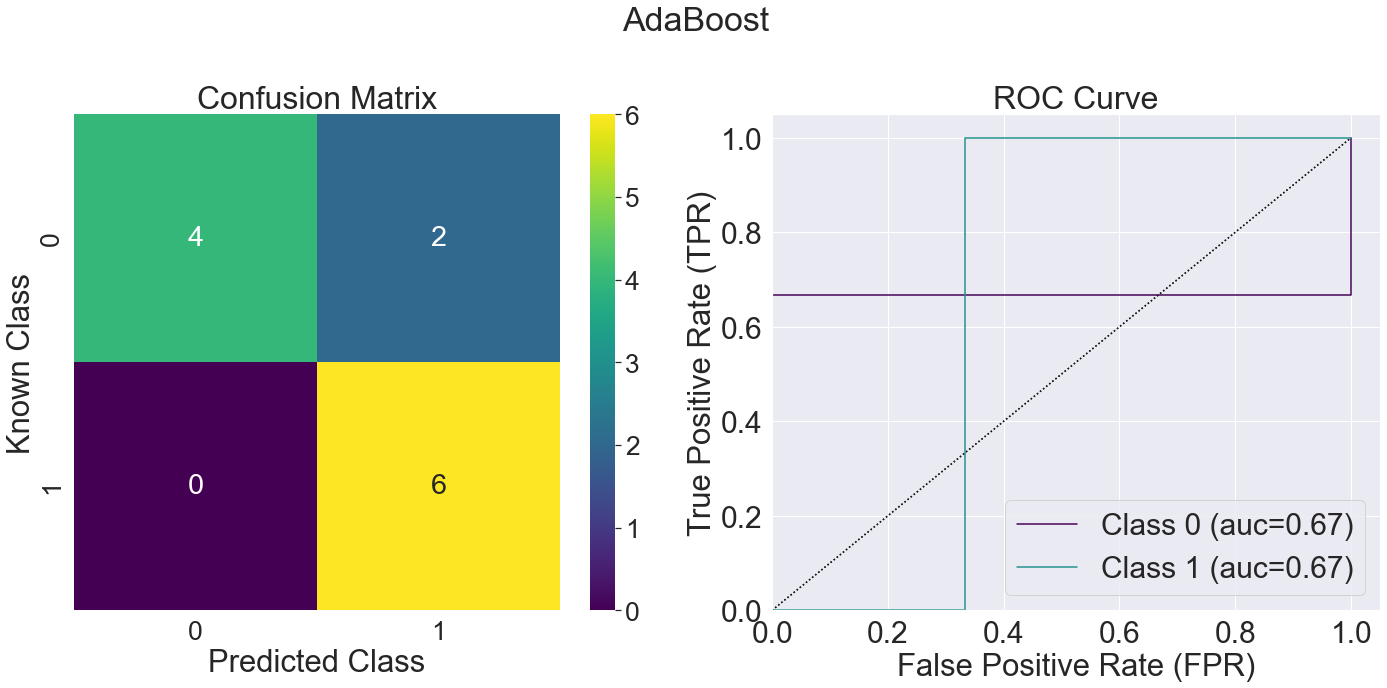

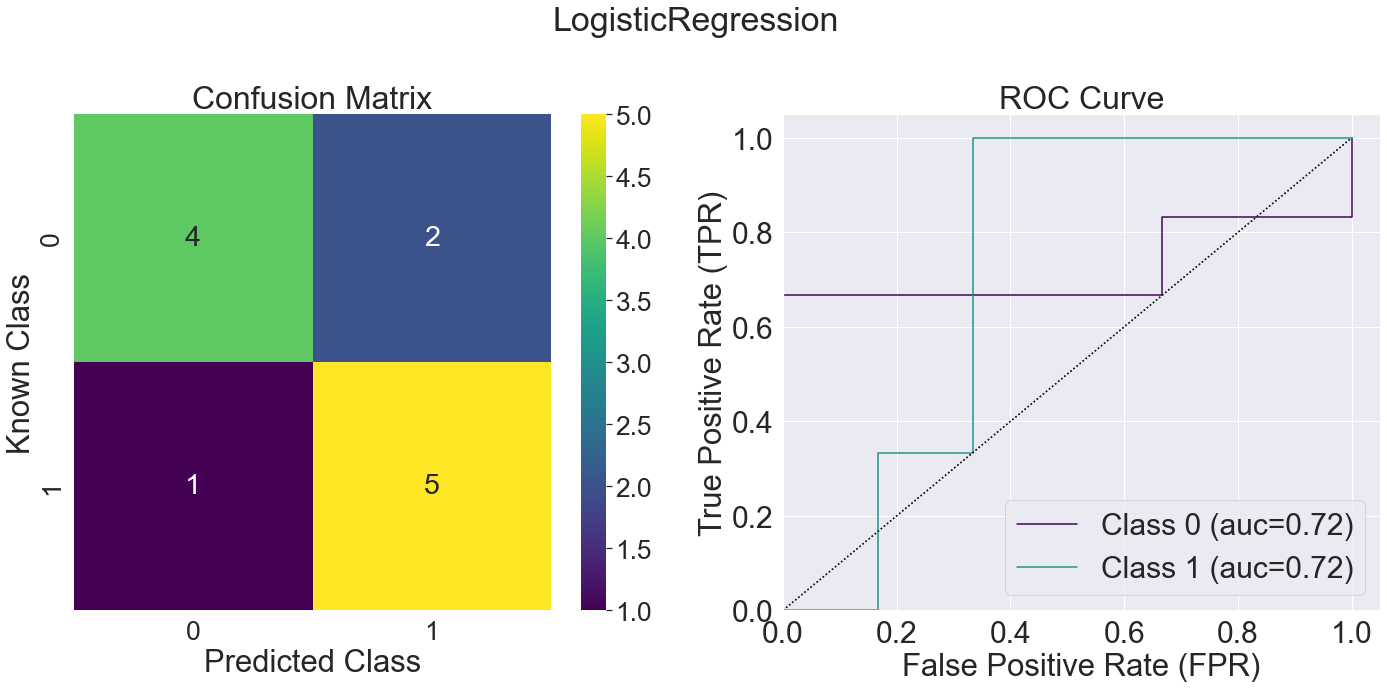

In [41]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier","RandomForest", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    
    probs = data[["prob0", "prob1"]].to_numpy()
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_dft.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))

    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_DFT.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from DFT features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:DFT_features")
log.info(df_metrics_for_paper.to_latex())

In [42]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_DFT.png")

Combining 7 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:21000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000
Image 5 added at offset height 15000
Image 6 added at offset height 18000


In [43]:
for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    wf.which_are_misclassified(data, known_column_label="known", predicted_column_label="prediction", return_indx=False)


NearestNeighbors
-------------

Reading 0.csv
         known  prediction  prob0  prob1
m_index                                 
0          1.0         1.0    0.2    0.8
1          0.0         1.0    0.0    1.0
2          1.0         1.0    0.4    0.6
3          0.0         0.0    1.0    0.0
4          1.0         1.0    0.4    0.6
...        ...         ...    ...    ...
7          0.0         1.0    0.2    0.8
8          0.0         0.0    1.0    0.0
9          1.0         1.0    0.2    0.8
10         0.0         0.0    1.0    0.0
11         1.0         1.0    0.4    0.6

[12 rows x 4 columns]

GaussianProcess
-------------

Reading 0.csv
         known  prediction     prob0     prob1
m_index                                       
0          1.0         1.0  0.097449  0.902551
1          0.0         1.0  0.024492  0.975508
2          1.0         1.0  0.415927  0.584073
3          0.0         0.0  0.834954  0.165046
4          1.0         1.0  0.276486  0.723514
...        ...        

# Interpetability with SHAP

Choose the classifier that performs the best

In [44]:
classifier = RandomForestClassifier

In [45]:
#loading and preparing the data
X = features_smote_df
X = scaling.autoscale(X)
y = classes_smote_df
columns = features_smote_df.columns.tolist()

kf = KFold(n_splits=5,shuffle=True)

list_shap_values = list()
list_test_sets = list()
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = pd.DataFrame(X_train,columns=columns)
    X_test = pd.DataFrame(X_test,columns=columns)

    #training model
    clf = classifier(random_state=0)
    clf.fit(X_train, y_train)

    #explaining model
    explainer = shap.KernelExplainer(clf.predict_proba, X_train)
    
#     For tree like models you can use
#     explainer = shap.TreeExplainer(clf)
    
    shap_values = explainer.shap_values(X_test)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)
    list_test_sets.append(test_index)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Using 118 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|                                                    | 0/30 [00:00<?, ?it/s]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.0064621 ,  0.03299346, -0.00274171,  0.00452735,  0.03683341,
        0.00593838,  0.00911262, -0.03721204, -0.05387632, -0.05273725,
        

num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        , -0.04014531, -0.00427589,  0.        , -0.00394465,
       -0.01374258,  0.        , -0.01309947, -0.00891182, -0.00538219,
       -0.01145049, -0.02177242, -0.00119973, -0.00252089,  0.        ,
       -0.0045013 , -0.00663894,  0.        , -0.01285931, -0.0075651 ,
       -0.00337018, -0.00733411, -0.0039218 ,  0.        , -0.01150992,
       -0.0014996 ,  0.        , -0.06241995, -0.00855326, -0.00679444,
       -0.01739273, -0.00335399, -0.01089332, -0.01942954, -0.00111346,
        0.        , -0.0043514 , -0.0229826 , -0.00992891, -0.00291428,
       -0.01683666, -0.03681046, -0.00383975, -0.0030107 ])
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([0.        , 0.04014531, 0.00427589, 0.        , 0.00394465,
       0.01374258, 0.        , 0.01309947, 0.00891182, 0.00538219,
       0.01145049, 0.02177242, 0.00119973, 0.002

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00301602, -0.0300733 ,  0.        , -0.00146971, -0.027286  ,
       -0.00395894, -0.00686631,  0.        , -0.00445873, -0.00285614,
       -0.01594982, -0.0144984 , -0.00453891,  0.        , -0.0028412 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00476959,  0.        , -0.00760393, -0.00165881,  0.        ,
       -0.000568  , -0.01073606, -0.11800377,  0.        ,  0.        ,
       -0.00989467,  0.        , -0.03121414,  0.        ,  0.        ,
        0.        ,  0.        , -0.02619237, -0.00753779,  0.        ,
       -0.03255601, -0.02518021,  0.        ,  0.        ])
 30%|█████████████▏                              | 9/30 [00:19<00:45,  2.17s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685,

 43%|██████████████████▋                        | 13/30 [00:27<00:34,  2.03s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([ 0.00692869,  0.04226643,  0.02099243, -0.00344143,  0.02388027,
        0.01145378,  0.01591692,  0.00559972,  0.        , -0.01706137,
       -0.01136259, -0.00980613,  0.        , -0.00405936, -0.00289795,
        0.00146935,  0.01795182,  0.00600639, -0.00662947,  0.00357215,
        0.        ,  0.04883985,  0.        ,  0.01004283, -0.01029415,
       -0.0044801 ,  0.00448449, -0.04458163, -0.00467249,  0.        ,
   

np.sum(w_aug) = 44.000000000000014
np.sum(self.kernelWeights) = 1.0
phi = array([-0.01659051, -0.094796  , -0.0221461 , -0.00303872, -0.05515114,
       -0.02737821, -0.01169328, -0.02600976, -0.00744957, -0.00492855,
        0.01632908,  0.00973681,  0.00637048,  0.00857545,  0.00068126,
        0.00403013,  0.0011647 ,  0.        ,  0.00905047,  0.00351532,
        0.00909592,  0.01139764,  0.00668471, -0.00075356,  0.01223966,
        0.00826629,  0.01341273,  0.06121479,  0.01711179, -0.00428927,
        0.01806037, -0.00409165,  0.00983551,  0.01419401, -0.00524205,
        0.00147453, -0.00447952,  0.0106731 ,  0.        ,  0.00323777,
        0.015519  , -0.01172086,  0.00840976,  0.00574865])
 60%|█████████████████████████▊                 | 18/30 [00:37<00:23,  1.99s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685

remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([-0.01339168, -0.03583171,  0.        ,  0.        , -0.02461142,
        0.        ,  0.        ,  0.        ,  0.0055767 ,  0.00354902,
        0.01739231,  0.02115415,  0.00462639,  0.        ,  0.        ,
        0.        ,  0.00388601,  0.        ,  0.02499642,  0.        ,
        0.01242865,  0.        ,  0.00747556,  0.00137468,  0.06684519,
        0.00339374,  0.00478553,  0.09287543,  0.        ,  0.01241721,
        0.01639086,  0.        ,  0.03390749,  0.04387466,  0.        ,
        0.0018824 ,  0.00495049,

np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00256558, -0.00855615,  0.        ,  0.        ,  0.        ,
       -0.00568299, -0.00873544, -0.00166643, -0.00633694, -0.00667142,
       -0.01713791, -0.01022447, -0.00137221, -0.01361103,  0.        ,
       -0.00792448, -0.01712782, -0.00152664,  0.        , -0.01804437,
        0.        , -0.02935958, -0.00459753, -0.00166453, -0.03305825,
        0.        , -0.00281638, -0.09303546, -0.02146539, -0.01941706,
       -0.01049396, -0.00151083, -0.02490541,  0.        , -0.00112725,
       -0.00117728, -0.0029272 , -0.01932259, -0.01554971, -0.00294932,
       -0.03665897, -0.03994834, -0.01136499, -0.0031949 ])
 90%|██████████████████████████████████████▋    | 27/30 [00:55<00:06,  2.06s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 

  3%|█▍                                          | 1/30 [00:02<00:58,  2.02s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        ,  0.02110411,  0.        , -0.00924754,  0.03330861,
       -0.02005125, -0.01326143, -0.00231588,  0.02713634,  0.        ,
       -0.0186319 , -0.00911969, -0.00094062, -0.01087281, -0.00594697,
       -0.00736917,  0.        , -0.00184347, -0.01235006, -0.0171958 ,
       -0.00393333, -0.01068097,  0.        , -0.00214149, -0.02438543,
        0.        ,  0.        , -0.06350447, -0.02027719, -0.01224853,
       -0.01551578

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([0.00484148, 0.04072632, 0.00472162, 0.        , 0.03213701,
       0.02818081, 0.03836452, 0.00434739, 0.        , 0.        ,
       0.01726665, 0.01211667, 0.        , 0.01406569, 0.00174831,
       0.00553999, 0.        , 0.        , 0.0161893 , 0.01399556,
       0.00503487, 0.00901561, 0.        , 0.00047419, 0.03287303,
       0.        , 0.00138174, 0.05144903, 0.00924397, 0.01589058,
       0.01103513, 0.        , 0.00234485, 0.02511515, 0.        ,
       0.        , 0.00844273, 0.01156554, 0.00600662, 0.00079563,
       0.041539  , 0.01546091, 0.0021398 , 0.00078078])
 20%|████████▊                                   | 6/30 [00:12<00:50,  2.10s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       

 33%|██████████████▎                            | 10/30 [00:21<00:42,  2.12s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        , -0.03768497, -0.0037479 ,  0.        , -0.06007458,
       -0.01431566, -0.0408217 ,  0.        , -0.00774059,  0.        ,
        0.        ,  0.        , -0.00392809, -0.00995077, -0.00347094,
       -0.00378402,  0.        , -0.00248887, -0.00561167, -0.00470937,
       -0.00138486, -0.01394824, -0.00846225,  0.        , -0.02849066,
        0.        , -0.00519959, -0.05409551,  0.        , -0.03049768,
       -0.00302226

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        , -0.02627505, -0.00341233,  0.        , -0.06852792,
       -0.01099443, -0.01135044, -0.00046219, -0.00919513, -0.01067077,
       -0.02037276, -0.01099216,  0.        ,  0.        , -0.00321984,
       -0.00277453,  0.        ,  0.        , -0.05722349,  0.        ,
       -0.00766246,  0.        , -0.00691333, -0.00137104,  0.        ,
       -0.00618073, -0.00854298, -0.10868524, -0.03126379,  0.        ,
       -0.00334792, -0.0008837 , -0.00459015,  0.        ,  0.        ,
       -0.00789264, -0.00712536, -0.01715816,  0.        , -0.00572584,
        0.        , -0.00703255, -0.00532256,  0.        ])
 50%|█████████████████████▌                     | 15/30 [00:31<00:32,  2.16s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685,

 63%|███████████████████████████▏               | 19/30 [00:40<00:23,  2.11s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.03267126,  0.04625759,  0.01117399,  0.01965357,  0.10456809,
        0.00630845,  0.05957204,  0.02541126,  0.02100071,  0.00680661,
       -0.01962571, -0.01378556,  0.        , -0.01500858, -0.00220999,
       -0.00243073,  0.00152818,  0.        , -0.01523277, -0.01418768,
        0.        , -0.01067343,  0.00237954,  0.00263066, -0.02455634,
       -0.00574037, -0.01021462, -0.03068106, -0.0158353 ,  0.        ,
       -0.01206798

np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.0069723 , -0.00926409,  0.00785223,  0.00470933,  0.01237433,
       -0.0305269 , -0.0027453 , -0.00387846, -0.01332087, -0.00861074,
       -0.01435612, -0.00978014, -0.00367113,  0.0111012 , -0.00336925,
       -0.00279156, -0.00483151, -0.00354703, -0.06327573,  0.00940252,
        0.        ,  0.        , -0.00922179, -0.00165521,  0.01149566,
       -0.00580955, -0.00554212, -0.08901801, -0.02329019,  0.01337047,
       -0.00414367, -0.00351528, -0.00312765,  0.        ,  0.        ,
       -0.00238895, -0.00465523, -0.01756736,  0.        , -0.00580522,
        0.01904448, -0.00783835,  0.        ,  0.        ])
 80%|██████████████████████████████████▍        | 24/30 [00:50<00:12,  2.05s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 

num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        ,  0.02482659,  0.0047641 ,  0.00376337,  0.07342126,
        0.01488547,  0.01380252, -0.00887195,  0.00295179, -0.02304546,
        0.01911522,  0.00873963,  0.        ,  0.        ,  0.005588  ,
        0.        ,  0.00514485,  0.        ,  0.0480948 ,  0.        ,
        0.        ,  0.        ,  0.00329625,  0.00111135, -0.01089077,
        0.00812581,  0.        ,  0.08939933,  0.03509247, -0.00950675,
        0.00260215,  0.00283489,  0.00423903,  0.        ,  0.        ,
        0.00558037,  0.00642995,  0.00749391,  0.        ,  0.00548405,
        0.        ,  0.00787101,  0.00282625,  0.        ])
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        , -0.02482659, -0.0047641 , -0.00376337, -0.07342126,
       -0.01488547, -0.01380252,  0.00887195, -0.00295179,  0.02304546,
       -0.01911522, -0.00873963,  0.  

np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([0.        , 0.        , 0.02096758, 0.00962097, 0.        ,
       0.00797567, 0.00017597, 0.00364212, 0.        , 0.01670238,
       0.0418688 , 0.0169255 , 0.        , 0.01418533, 0.01031312,
       0.01266916, 0.        , 0.00117106, 0.00385111, 0.00616583,
       0.00267761, 0.01260958, 0.        , 0.00251317, 0.01903527,
       0.        , 0.00360852, 0.06331456, 0.01187638, 0.00556753,
       0.02447529, 0.00274277, 0.0073367 , 0.03381015, 0.00841377,
       0.        , 0.0116316 , 0.02743413, 0.02232542, 0.00178316,
       0.03493948, 0.05842295, 0.0022982 , 0.        ])
 10%|████▍                                       | 3/30 [00:06<00:55,  2.04s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0

 23%|██████████▎                                 | 7/30 [00:14<00:46,  2.01s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([ 0.05809106,  0.00894124,  0.05972975,  0.02878305, -0.03247547,
       -0.00214576, -0.0205798 ,  0.00414837, -0.01502532,  0.        ,
       -0.00399956, -0.00578246, -0.00541389, -0.01331526, -0.00159172,
       -0.01889717,  0.        , -0.00308659,  0.        , -0.00791073,
       -0.00241227, -0.01966839, -0.02001898,  0.        , -0.01127191,
       -0.00305846,  0.        , -0.04119858, -0.00630275, -0.00342899,
        0.      

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([0.00740683, 0.03282834, 0.01585107, 0.00571616, 0.01595707,
       0.00318772, 0.00251594, 0.        , 0.        , 0.00252925,
       0.05297881, 0.        , 0.0072736 , 0.01920816, 0.        ,
       0.        , 0.00656676, 0.        , 0.00969002, 0.00700529,
       0.00301912, 0.0132397 , 0.        , 0.00294602, 0.02020651,
       0.00321407, 0.00455834, 0.06006637, 0.01043956, 0.00755275,
       0.        , 0.        , 0.00822246, 0.00761423, 0.00464107,
       0.01618329, 0.01135072, 0.02207853, 0.01954577, 0.0036565 ,
       0.0550343 , 0.05724703, 0.00351949, 0.        ])
 40%|█████████████████▏                         | 12/30 [00:24<00:37,  2.08s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       

 53%|██████████████████████▉                    | 16/30 [00:32<00:28,  2.05s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00418377,  0.01231541, -0.01297661, -0.00610709,  0.01439179,
        0.        ,  0.        ,  0.        ,  0.01167575,  0.0055648 ,
        0.0222992 ,  0.        , -0.00508818, -0.01982716,  0.        ,
        0.01091357, -0.02524533, -0.01578481, -0.01108689, -0.00931209,
       -0.00527478, -0.03247797, -0.04303396, -0.00242036, -0.0190508 ,
        0.        , -0.0097219 , -0.0481731 , -0.0142894 , -0.00775093,
        0.00756824

np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00163711, -0.01439773, -0.04387242,  0.00810843,  0.03463283,
       -0.01034164,  0.00658745, -0.00880045, -0.01108976, -0.00850021,
        0.04795021,  0.01932183,  0.00642413,  0.01331772,  0.        ,
        0.00326485,  0.        , -0.00237863,  0.00597338,  0.00562569,
        0.00393916,  0.01342665, -0.00650559,  0.        ,  0.01818774,
        0.00184183,  0.        ,  0.05100411,  0.00357629,  0.        ,
        0.01612622,  0.        ,  0.01455912,  0.01090424, -0.00660991,
        0.01497389, -0.004832  ,  0.01202015, -0.01004746, -0.00538815,
        0.02506154, -0.00937553,  0.        ,  0.        ])
 70%|██████████████████████████████             | 21/30 [00:43<00:18,  2.11s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 

 83%|███████████████████████████████████▊       | 25/30 [00:51<00:09,  2.00s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([0.00265189, 0.00519138, 0.01059236, 0.        , 0.        ,
       0.00227178, 0.00444259, 0.        , 0.        , 0.00045265,
       0.03678728, 0.01285192, 0.        , 0.02996184, 0.00309431,
       0.00749777, 0.00146643, 0.        , 0.00237492, 0.02076008,
       0.00608272, 0.02866182, 0.00607652, 0.        , 0.03627515,
       0.00463191, 0.        , 0.05306572, 0.00887434, 0.00881426,
       0.01073875, 0.00090607, 0.        , 0.032

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([ 0.00229113, -0.00872152, -0.0234944 ,  0.        , -0.00802903,
       -0.0022985 , -0.00670508,  0.        ,  0.01632963,  0.00540691,
        0.06016205, -0.01380701,  0.        ,  0.00712137, -0.00777808,
       -0.0040645 ,  0.        ,  0.        ,  0.        ,  0.00393614,
        0.00253851,  0.00759227, -0.00421199,  0.00474979, -0.04979033,
        0.        ,  0.        ,  0.02268483,  0.        ,  0.        ,
       -0.01041728,  0.        , -0.03015386, -0.00214944,  0.00353077,
        0.0066071 , -0.00269891,  0.02053267, -0.0190409 , -0.00399261,
       -0.05150989, -0.02058246,  0.        , -0.00098655])
100%|███████████████████████████████████████████| 30/30 [01:01<00:00,  2.04s/it]
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Using 119 background data samples could cause slower run times.

 14%|██████                                      | 4/29 [00:08<00:54,  2.18s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00180526,  0.01868981, -0.02154183,  0.        , -0.04937829,
       -0.02471017,  0.01340459, -0.00615601, -0.00655894, -0.00541408,
        0.00887865,  0.00897034, -0.01347496, -0.00362159,  0.        ,
       -0.00040113, -0.00580308,  0.        , -0.00424409, -0.00655335,
        0.00584407, -0.01747641, -0.00558038, -0.00648838, -0.03051099,
        0.00878744, -0.00756792, -0.0507786 ,  0.00902756, -0.00648699,
        0.01225898, -0.00653409

np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.00258062, -0.01812429,  0.        , -0.00205031, -0.02822124,
       -0.00761691,  0.        , -0.00347889, -0.00261453, -0.01106371,
       -0.03576414, -0.02214868, -0.00210745, -0.0013959 , -0.00368711,
        0.        , -0.00248762,  0.        ,  0.        , -0.00132961,
        0.        ,  0.        , -0.00287594, -0.00165015, -0.05743931,
        0.        , -0.01292849, -0.10348007,  0.        , -0.00296127,
       -0.02148748, -0.0011151 , -0.02980244, -0.00752757,  0.        ,
       -0.00353917, -0.00391338, -0.02801053, -0.00384843,  0.        ,
       -0.06555213, -0.02373536,  0.        ,  0.        ])
 31%|█████████████▋                              | 9/29 [00:19<00:43,  2.18s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 

 45%|███████████████████▎                       | 13/29 [00:28<00:34,  2.16s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([ 0.02707407, -0.0494514 ,  0.05440759, -0.01328236,  0.00206616,
        0.00822393,  0.01016593,  0.00384053,  0.00455045,  0.01610394,
       -0.011841  , -0.00430185,  0.00312329,  0.01221223,  0.0002718 ,
        0.00205985,  0.02950139,  0.01666741, -0.01186304,  0.01527618,
       -0.00187591,  0.01693641,  0.00479219,  0.01764318, -0.01793722,
        0.00126227,  0.00631789, -0.04969047, -0.00428119,  0.        ,
   

np.sum(w_aug) = 44.000000000000014
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.00294502, -0.02214794,  0.        ,  0.01680869, -0.02473308,
        0.        ,  0.02062161,  0.00639512,  0.        ,  0.01345575,
        0.05176064,  0.02641874,  0.00637049,  0.00610561,  0.        ,
        0.00270668,  0.        ,  0.        ,  0.01399847,  0.00618939,
        0.        ,  0.00899801,  0.0068563 ,  0.00905346,  0.02610129,
        0.00664761,  0.02510567,  0.05158948,  0.00937622,  0.00715981,
        0.04387429,  0.        ,  0.00681811,  0.0198408 ,  0.00106997,
        0.01058613,  0.        ,  0.0115494 ,  0.        ,  0.0093395 ,
        0.025731  ,  0.00470785,  0.00825176,  0.00591034])
 62%|██████████████████████████▋                | 18/29 [00:39<00:23,  2.17s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685

 76%|████████████████████████████████▌          | 22/29 [00:47<00:14,  2.12s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([0.00137832, 0.00800539, 0.        , 0.        , 0.        ,
       0.00618017, 0.00149924, 0.        , 0.        , 0.0075588 ,
       0.0260949 , 0.0197969 , 0.00297195, 0.        , 0.00648276,
       0.00261748, 0.00336286, 0.        , 0.02899244, 0.        ,
       0.        , 0.        , 0.0035877 , 0.00171403, 0.05545076,
       0.00416493, 0.01035323, 0.07802146, 0.        , 0.00380336,
       0.02251652, 0.00131502, 0.02705526, 0.050

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([-0.01085263, -0.03630244,  0.00145486,  0.01744932, -0.11700319,
       -0.02335227,  0.        , -0.00304207, -0.0138316 ,  0.00891649,
        0.03716768,  0.01879616,  0.0073477 ,  0.00368163,  0.        ,
        0.00194098,  0.        ,  0.        ,  0.00868793,  0.0043824 ,
       -0.00382869,  0.00664616,  0.00804282,  0.00403045,  0.01949034,
        0.00175945,  0.0131435 ,  0.05100341,  0.00657171,  0.00631442,
        0.03325546,  0.        ,  0.00516845,  0.01656265,  0.        ,
        0.00637736,  0.        ,  0.01010509, -0.00552702,  0.00662885,
        0.02522212, -0.00429559,  0.        ,  0.00335026])
 93%|████████████████████████████████████████   | 27/29 [00:57<00:04,  2.15s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685,

  7%|███                                         | 2/29 [00:04<01:00,  2.24s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([-0.0072494 , -0.02005731, -0.00450137, -0.00159678, -0.0178001 ,
        0.        ,  0.        , -0.07956824, -0.06695045, -0.10066197,
        0.01505541,  0.00290958,  0.01139283, -0.00645735,  0.        ,
        0.00902484, -0.00588435,  0.        ,  0.        , -0.00745698,
        0.        , -0.00743553,  0.00330818,  0.        , -0.00638847,
       -0.00681602,  0.00484911,  0.0609135 ,  0.        , -0.02368264,
        0.0070857 ,  0.        

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([0.00124812, 0.0021433 , 0.01419163, 0.00606751, 0.01570727,
       0.00056763, 0.00480947, 0.00759357, 0.01461885, 0.00451357,
       0.01768453, 0.00582648, 0.        , 0.00985355, 0.00200566,
       0.00736008, 0.00584287, 0.        , 0.01515532, 0.01242543,
       0.00512939, 0.01096421, 0.        , 0.00094537, 0.01652148,
       0.0014434 , 0.00169025, 0.06342876, 0.01022833, 0.00147816,
       0.01761934, 0.        , 0.02036832, 0.02205638, 0.        ,
       0.        , 0.01092069, 0.02882996, 0.00882502, 0.00308548,
       0.03184117, 0.06418482, 0.00639426, 0.00432953])
 24%|██████████▌                                 | 7/29 [00:14<00:45,  2.07s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       

 38%|████████████████▎                          | 11/29 [00:23<00:37,  2.06s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.0
np.sum(self.kernelWeights) = 1.0
phi = array([0.        , 0.00653781, 0.        , 0.        , 0.01448719,
       0.00291386, 0.        , 0.00019142, 0.00186251, 0.00832512,
       0.03002439, 0.00776441, 0.0104213 , 0.        , 0.        ,
       0.01310159, 0.        , 0.00044533, 0.        , 0.        ,
       0.01171357, 0.        , 0.00817542, 0.0014068 , 0.02776011,
       0.00181357, 0.01194119, 0.11267757, 0.        , 0.00449942,
       0.00884872, 0.        , 0.0497147 , 0.00810326, 0.    

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([ 0.0169585 ,  0.02241993,  0.00651849, -0.04314461,  0.02034181,
       -0.00632317,  0.0067252 , -0.01234235, -0.00582444,  0.02832982,
        0.02815276,  0.01054394,  0.01064677,  0.00462514,  0.        ,
        0.01242418,  0.        ,  0.        ,  0.01388328,  0.00839072,
        0.00386191,  0.01297102,  0.00193453,  0.        ,  0.01771998,
        0.01166061,  0.00533894,  0.07019314,  0.01121063,  0.        ,
        0.02603199,  0.        ,  0.024812  ,  0.02196862,  0.        ,
        0.00362002,  0.        ,  0.0243252 ,  0.        ,  0.        ,
        0.02356529, -0.02694322,  0.        ,  0.00330255])
 55%|███████████████████████▋                   | 16/29 [00:33<00:26,  2.01s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.033978

 69%|█████████████████████████████▋             | 20/29 [00:41<00:18,  2.01s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685, 0.03106636, 0.02999511, 0.02912471,
       0.02842674, 0.02788007, 0.0274692 , 0.02718307, 0.02701423,
       0.02695841])
num_paired_subset_sizes = 21
weight_left = 0.7647687038089407
np.sum(w_aug) = 44.000000000000014
np.sum(self.kernelWeights) = 1.0000000000000002
phi = array([0.        , 0.00270956, 0.        , 0.        , 0.01377626,
       0.0020159 , 0.        , 0.        , 0.00389372, 0.0073273 ,
       0.02290122, 0.00183799, 0.        , 0.02477086, 0.        ,
       0.00348301, 0.        , 0.        , 0.02670702, 0.02183309,
       0.        , 0.03128754, 0.00507659, 0.        , 0.01968471,
       0.00762191, 0.        , 0.08523432, 0.02022834, 0.00707184,
       0.00953323, 0.0019221 , 0

np.sum(w_aug) = 44.00000000000001
np.sum(self.kernelWeights) = 1.0
phi = array([ 0.        , -0.00798626,  0.        ,  0.        , -0.02191618,
       -0.00655896,  0.        ,  0.        , -0.00479489, -0.00794683,
       -0.03445058, -0.0120437 , -0.0060459 ,  0.        ,  0.        ,
       -0.00813262,  0.        ,  0.        , -0.05072004,  0.        ,
       -0.00301479,  0.        , -0.00772841,  0.        ,  0.        ,
        0.        , -0.0014681 , -0.12157305, -0.02646851,  0.        ,
       -0.01013116, -0.00165806,  0.        , -0.01440947,  0.        ,
       -0.00182845, -0.00083214, -0.02631511,  0.        , -0.00417306,
        0.        , -0.04190457,  0.        ,  0.        ])
 86%|█████████████████████████████████████      | 25/29 [00:50<00:07,  1.95s/it]num_full_subsets = 1
remaining_weight_vector = array([0.15533181, 0.10608026, 0.0815492 , 0.06691217, 0.05722751,
       0.05037788, 0.04530511, 0.04142182, 0.03837609, 0.03594455,
       0.03397883, 0.03237685,

100%|███████████████████████████████████████████| 29/29 [00:58<00:00,  2.03s/it]


In [46]:
list_test_sets[0]

array([  6,  14,  20,  21,  24,  46,  47,  53,  55,  61,  64,  67,  68,
        76,  77,  88,  90,  96, 102, 104, 105, 107, 112, 115, 118, 121,
       124, 131, 135, 137])

In [47]:
list_shap_values[0]

[array([[ 0.0064621 ,  0.03299346, -0.00274171, ...,  0.01069304,
          0.        ,  0.        ],
        [ 0.        , -0.0005153 , -0.01927986, ..., -0.04777351,
          0.        , -0.0039803 ],
        [-0.01504319, -0.04613266, -0.01443761, ..., -0.03285935,
         -0.00248756, -0.00214656],
        ...,
        [ 0.0101137 ,  0.03661773,  0.        , ...,  0.01956473,
          0.        ,  0.        ],
        [ 0.        ,  0.00439056,  0.        , ...,  0.04206328,
          0.0017708 ,  0.        ],
        [ 0.00215728,  0.01900711,  0.        , ...,  0.04088666,
          0.0008695 ,  0.        ]]),
 array([[-0.0064621 , -0.03299346,  0.00274171, ..., -0.01069304,
          0.        ,  0.        ],
        [ 0.        ,  0.0005153 ,  0.01927986, ...,  0.04777351,
          0.        ,  0.0039803 ],
        [ 0.01504319,  0.04613266,  0.01443761, ...,  0.03285935,
          0.00248756,  0.00214656],
        ...,
        [-0.0101137 , -0.03661773,  0.        , ..., -

In [48]:
#combining results from all iterations
test_set = list_test_sets[0]
shap_values = np.array(list_shap_values[0])
for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
#bringing back variable names    
X_test = pd.DataFrame(X.iloc[test_set],columns=columns)
     

In [49]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
6,-0.489035,0.978683,0.765780,-0.520675,-1.113841,0.632660,0.088910,0.742692,-3.002039,0.460532,...,-0.693695,-0.124117,1.347954,-0.306582,0.823664,0.519516,-0.229289,0.508269,0.675415,0.878892
14,2.129003,-0.411031,-0.071073,2.219190,1.686012,1.276843,0.856456,0.539688,0.816227,0.376362,...,-0.509685,0.436545,-0.565990,-0.136507,0.986324,0.172055,0.877755,0.838197,0.110161,0.878892
20,-0.971305,-1.337508,0.974993,-0.426197,0.697217,1.476762,1.130580,0.539688,0.499017,0.390391,...,-0.509685,0.436545,-0.565990,-0.136507,0.986324,0.172055,0.877755,0.838197,0.110161,0.878892
21,1.646733,-0.853213,0.347354,1.994804,1.384170,1.010285,0.107185,0.565064,1.391904,0.993604,...,-0.509685,0.436545,-0.565990,-0.136507,0.986324,0.172055,0.877755,0.838197,0.110161,0.878892
24,1.164463,-0.832157,-0.280286,-0.343529,0.291290,0.921432,0.162010,0.539688,0.275795,0.390391,...,-0.509685,0.436545,-0.565990,-0.136507,0.986324,0.172055,0.877755,0.838197,0.110161,0.878892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.479777,0.780632,0.554942,-0.342946,-0.808954,0.628183,0.098733,0.516018,1.141695,0.376362,...,-0.509685,0.159215,-0.536923,-0.283729,0.941267,0.107603,1.078041,0.209887,-0.135627,0.878892
129,-0.764618,-0.979551,0.661173,-0.485246,0.645175,0.965858,0.162010,0.552376,0.405029,0.390391,...,0.322022,1.759560,-1.660702,-1.710689,-1.961064,-2.322222,-2.034019,-1.946393,-2.358551,0.878892
130,-0.489035,0.978683,0.765780,-0.520675,-1.113841,0.632660,0.088910,0.514313,1.086442,0.376362,...,-0.614833,0.276356,-0.213421,-0.306582,-0.178317,0.549299,-0.667123,-0.151586,0.664899,0.878892
132,-0.618577,0.058184,0.716608,-0.504021,-0.286987,0.789285,0.123272,0.532205,0.766133,0.382956,...,0.194744,2.336023,-0.902736,-1.710689,-1.961064,-2.322222,-2.034019,-1.946393,-2.358551,0.878892


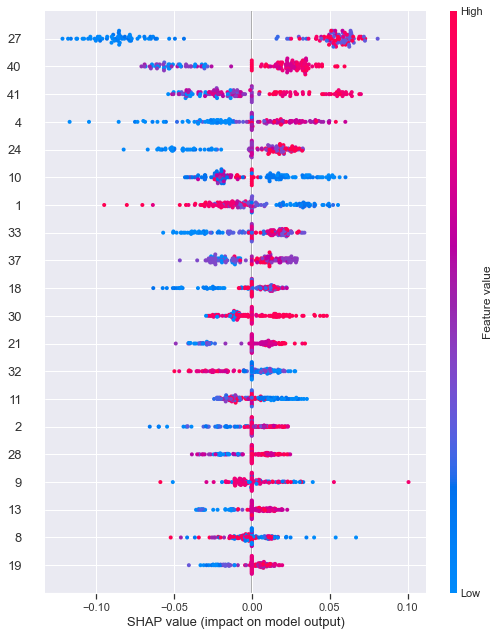

In [50]:
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
shap.summary_plot(shap_values[1], X_test)

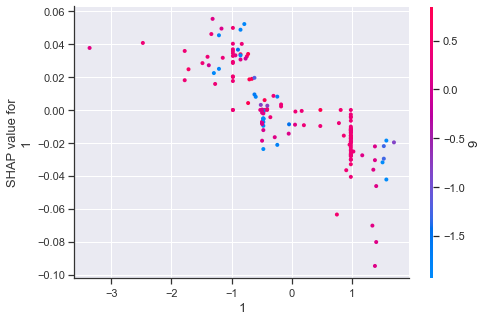

In [51]:
#dependence plot, the first number (1) is the index of the column to be plotted on the right 
# is the feature that may have an interaction with the chosen feature
shap.dependence_plot(1,shap_values[1], X_test)